## Homework

In this homework, we'll deploy the dino or dragon model we trained in the 
[previous homework](https://github.com/alexeygrigorev/mlbookcamp-code/blob/master/course-zoomcamp/cohorts/2022/08-deep-learning/homework.md).

Download the model from here: 

https://github.com/SVizor42/ML_Zoomcamp/releases/download/dino-dragon-model/dino_dragon_10_0.899.h5

In [1]:
import os
import tensorflow as tf
import tensorflow.lite as tflite
import numpy as np
from keras.models import load_model

In [ ]:
!wget https://github.com/SVizor42/ML_Zoomcamp/releases/download/dino-dragon-model/dino_dragon_10_0.899.h5

## Question 1

Now convert this model from Keras to TF-Lite format.

What's the size of the **converted** model?

* 21 Mb
* 43 Mb
* 80 Mb
* 164 Mb

In [4]:
model = load_model('./dino_dragon_10_0.899.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
lite_model = converter.convert()

with open('model.tflite', 'wb') as f_out:
    f_out.write(lite_model)

INFO:tensorflow:Assets written to: C:\Users\Kawba\AppData\Local\Temp\tmpehrbding\assets


INFO:tensorflow:Assets written to: C:\Users\Kawba\AppData\Local\Temp\tmpehrbding\assets


In [16]:
print(f"Size of lite model: {round(os.path.getsize('model.tflite')/((1024*1024)))} MB")

Size of lite model: 43 MB


**Answer**: 43 MB

## Question 2

To be able to use this model, we need to know the index of the input and 
the index of the output. 

What's the output index for this model?

* 3
* 7
* 13
* 24

In [19]:
interpreter = tflite.Interpreter(model_path='model.tflite')
interpreter.allocate_tensors()
input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']
print(f'output index is: {output_index}')

output index is: 13


**Answer**: 13

## Preparing the image

You'll need some code for downloading and resizing images. You can use 
this code:

```python
from io import BytesIO
from urllib import request

from PIL import Image

def download_image(url):
    with request.urlopen(url) as resp:
        buffer = resp.read()
    stream = BytesIO(buffer)
    img = Image.open(stream)
    return img


def prepare_image(img, target_size):
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img = img.resize(target_size, Image.NEAREST)
    return img
```

For that, you'll need to have `pillow` installed:

```bash
pip install pillow
```

Let's download and resize this image: 

https://upload.wikimedia.org/wikipedia/commons/thumb/d/df/Smaug_par_David_Demaret.jpg/1280px-Smaug_par_David_Demaret.jpg

Based on the previous homework, what should be the target size for the image?

In [ ]:
!pip install pillow

In [22]:
from io import BytesIO
from urllib import request

from PIL import Image

def download_image(url):
    with request.urlopen(url) as resp:
        buffer = resp.read()
    stream = BytesIO(buffer)
    img = Image.open(stream)
    return img


def prepare_image(img, target_size):
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img = img.resize(target_size, Image.NEAREST)
    return img

C:\Users\Kawba\AppData\Local\Temp\ipykernel_16520\2487457277.py:17: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  img = img.resize(target_size, Image.NEAREST)


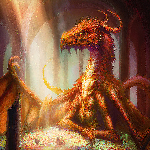

In [24]:
url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/d/df/Smaug_par_David_Demaret.jpg/1280px-Smaug_par_David_Demaret.jpg'
image = download_image(url)
# 150,150 last homework
image = prepare_image(image, target_size=(150, 150))
image

## Question 3

Now we need to turn the image into numpy array and pre-process it. 

> Tip: Check the previous homework. What was the pre-processing 
> we did there?

After the pre-processing, what's the value in the first pixel, the R channel?

* 0.3353411
* 0.5529412
* 0.7458824
* 0.9654902

In [44]:
def preprocess_input(image):
    x = np.array(image, dtype='float32')
    X = np.array([x])
    return X/255.0
X = preprocess_input(image)

In [45]:
print(f'The first R channel pixel value is: {X[0,0,0,0]}')

The first R channel pixel value is: 0.5529412031173706


**Answer**: 0.5529412

## Question 4

Now let's apply this model to this image. What's the output of the model?

* 0.17049132
* 0.39009996
* 0.60146114
* 0.82448614

In [42]:
interpreter.set_tensor(input_index, X)
interpreter.invoke()
predictions = interpreter.get_tensor(output_index)
print(f'The output of the model is {predictions[0][0]}')

The output of the model is 0.8244850635528564


**Answer**: 0.8244850635528564

## Docker 

For the next two questions, we'll use a Docker image that we already 
prepared. This is the Dockerfile that we used for creating the image:

```docker
FROM public.ecr.aws/lambda/python:3.9
COPY dino-vs-dragon-v2.tflite .
```

And pushed it to [`svizor42/zoomcamp-dino-dragon-lambda:v2`](https://hub.docker.com/r/svizor42/zoomcamp-dino-dragon-lambda/tags).

A few notes:

* The image already contains a model and it's not the same model
  as the one we used for questions 1-4.
* The version of Python is 3.9, so you need to use the right wheel for 
  TF-Lite. For Tensorflow 2.7.0, it's https://github.com/alexeygrigorev/tflite-aws-lambda/raw/main/tflite/tflite_runtime-2.7.0-cp39-cp39-linux_x86_64.whl

## Question 5

Download the base image `svizor42/zoomcamp-dino-dragon-lambda:v2`. You can easily make it by using [docker pull](https://docs.docker.com/engine/reference/commandline/pull/) command.

So what's the size of this base image?

* 139 Mb
* 329 Mb
* 639 Mb
* 929 Mb

You can get this information when running `docker images` - it'll be in the "SIZE" column.


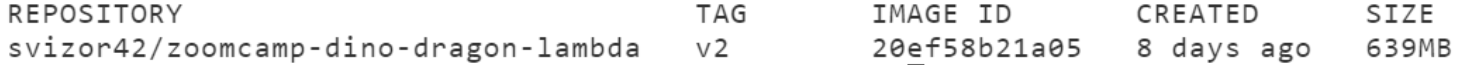
**Answer** 639 Mb



## Question 6

Now let's extend this docker image, install all the required libraries
and add the code for lambda.

You don't need to include the model in the image. It's already included. 
The name of the file with the model is `dino-vs-dragon-v2.tflite` and it's 
in the current workdir in the image (see the Dockerfile above for the 
reference).

Now run the container locally.

Score this image: https://upload.wikimedia.org/wikipedia/en/e/e9/GodzillaEncounterModel.jpg

What's the output from the model?

* 0.12
* 0.32
* 0.52
* 0.72


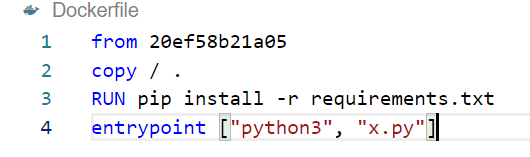 

**Answer**: 0.32